FRP

Total FRP points in CSV: 2022355
Number of unique days: 8795


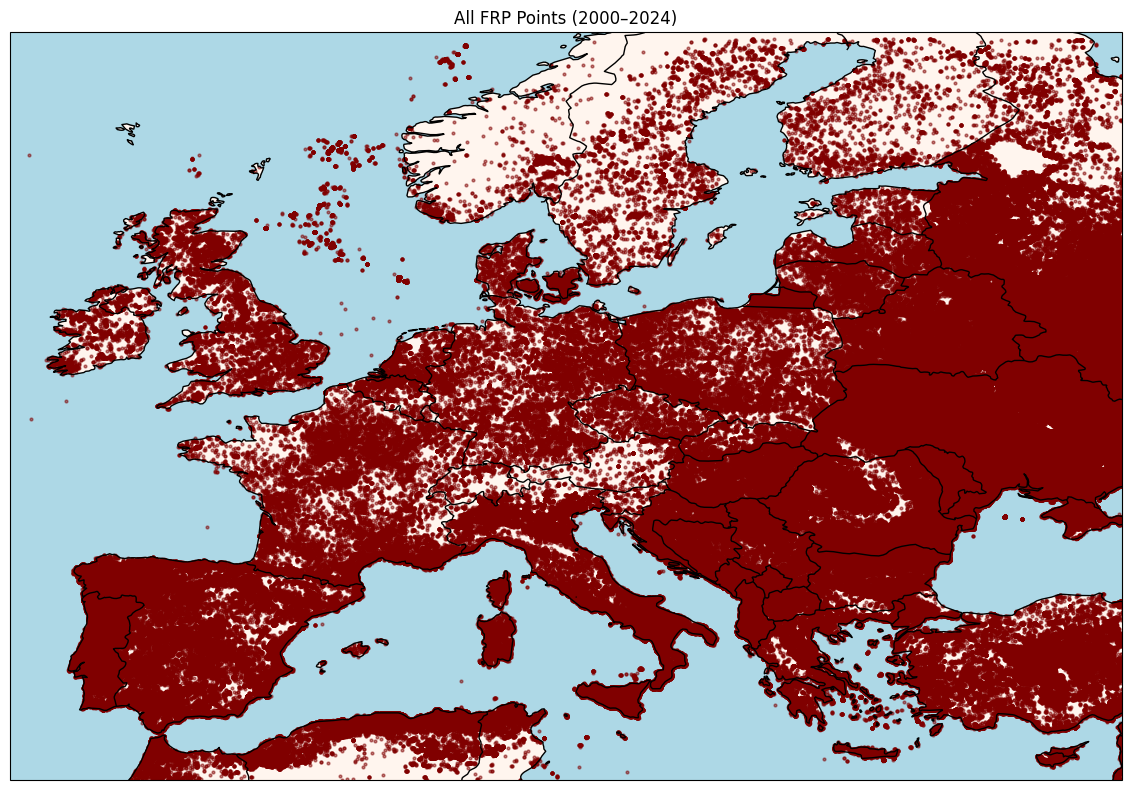

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,815,Terra,MODIS,60,6.03,294.4,13.2,D,0
1,49.5459,23.5306,326.6,1.0,1.0,2000-11-01,950,Terra,MODIS,84,6.03,286.4,21.9,D,0
2,49.5480,23.5170,347.1,1.0,1.0,2000-11-01,950,Terra,MODIS,95,6.03,291.3,53.6,D,0
3,48.7390,29.1738,306.8,1.5,1.2,2000-11-01,950,Terra,MODIS,33,6.03,287.7,13.7,D,0
4,49.5695,23.4383,303.8,1.0,1.0,2000-11-01,950,Terra,MODIS,57,6.03,286.8,5.6,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022350,44.5394,3.0130,300.9,1.2,1.1,2024-12-31,941,Terra,MODIS,43,61.03,276.7,9.9,D,0
2022351,40.3944,33.5275,311.0,1.2,1.1,2024-12-31,1130,Aqua,MODIS,71,61.03,283.6,16.0,D,0
2022352,40.8579,33.0911,300.0,1.2,1.1,2024-12-31,1130,Aqua,MODIS,22,61.03,280.7,8.5,D,0
2022353,45.2580,31.6737,311.4,1.2,1.1,2024-12-31,1131,Aqua,MODIS,48,61.03,282.5,17.0,D,3


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")

# Ensure lowercase columns for consistency
df.columns = [col.lower() for col in df.columns]

# Convert acquisition date to datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# === COUNTING POINTS AND UNIQUE DAYS ===
total_points = len(df)
unique_days = df['acq_date'].nunique()
print(f"Total FRP points in CSV: {total_points}")
print(f"Number of unique days: {unique_days}")

# Start the plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34, 64.3])

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot all FRP points with a uniform color
ax.scatter(df['longitude'], df['latitude'], color='maroon', s=4, alpha=0.5, transform=ccrs.PlateCarree())

# Title only, no colorbar
plt.title("All FRP Points (2000–2024)")
plt.tight_layout()
plt.show()
df


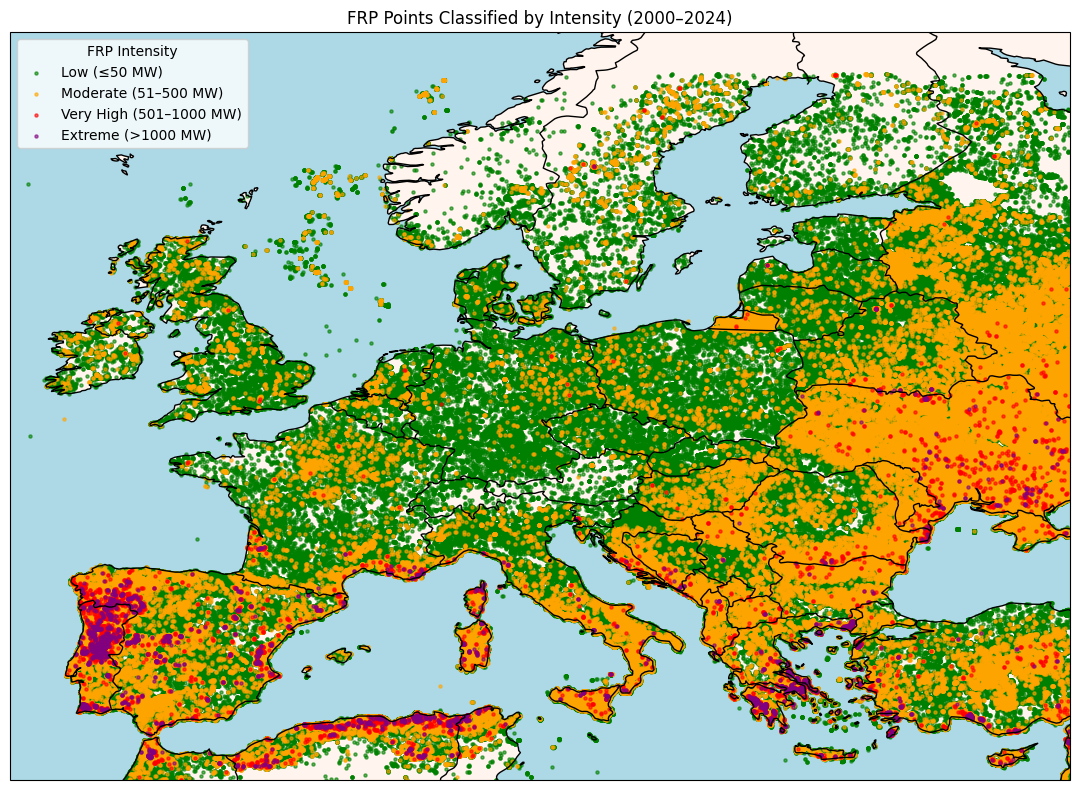

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load and prepare data
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")
df.columns = [col.lower() for col in df.columns]
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Classification bins and labels
bins = [0, 50, 500, 1000, float('inf')]
labels = ['Low (≤50 MW)', 'Moderate (51–500 MW)', 'Very High (501–1000 MW)', 'Extreme (>1000 MW)']
colors = ['green', 'orange', 'red', 'purple']

# Classify FRP into intensity categories
df['intensity'] = pd.cut(df['frp'], bins=bins, labels=labels, include_lowest=True)

# Begin plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34, 66])  # Study area extent

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot each category separately
for label, color in zip(labels, colors):
    cat_df = df[df['intensity'] == label]
    ax.scatter(cat_df['longitude'], cat_df['latitude'], label=label, color=color,
               s=5, alpha=0.6, transform=ccrs.PlateCarree())

# Add legend and title
plt.legend(title='FRP Intensity', loc='upper left')
plt.title("FRP Points Classified by Intensity (2000–2024)")
plt.tight_layout()
plt.show()


In [3]:
# Turn point dataset into gridded dataset, where its horizontal resolution is 0.75º*0.75º

import pandas as pd
import numpy as np
import xarray as xr
import os

# === INPUT CSV FILE ===
csv_path = r"E:\IPMA\FRP\FRP_2000_2024.csv"

# === EXTRACT DIRECTORY AND CREATE OUTPUT FILENAME ===
base_dir = os.path.dirname(csv_path)
output_filename = "FRP_2000_2024.nc"
output_path = os.path.join(base_dir, output_filename)

# === GRID PARAMETERS ===
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34, 66
lon_min, lon_max = -12, 36

lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]

# === LOAD AND PREPARE DATA ===
print("Loading and filtering data...")
df = pd.read_csv(csv_path)
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Filter out low-intensity values
df = df[df['frp'] >= 50]  # Only keep FRP values ≥ 50 MW

# Ensure date is datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Assign grid cell
print("Assigning points to grid cells...")
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_centers)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=lon_centers)
df.dropna(subset=['lat_bin', 'lon_bin'], inplace=True)

# Convert bins to float
df['lat_bin'] = df['lat_bin'].astype(float)
df['lon_bin'] = df['lon_bin'].astype(float)

# === AGGREGATE STATS ===
print("Aggregating FRP statistics...")
grouped = df.groupby(['acq_date', 'lat_bin', 'lon_bin'])

frp_stats = grouped['frp'].agg(
    FRP_sum='sum',
    FRP_mean='mean',
    FRP_median='median',
    FRP_max='max',
    FRP_min='min',
    FRP_std='std',
    count='count'
).reset_index()

# === CREATE FULL 3D ARRAYS ===
print("Creating 3D arrays...")

all_dates = pd.date_range(df['acq_date'].min(), df['acq_date'].max(), freq='D')
shape = (len(all_dates), len(lat_centers), len(lon_centers))

# Initialize arrays with NaNs
arrays = {
    'FRP_sum': np.full(shape, np.nan),
    'FRP_mean': np.full(shape, np.nan),
    'FRP_median': np.full(shape, np.nan),
    'FRP_max': np.full(shape, np.nan),
    'FRP_min': np.full(shape, np.nan),
    'FRP_std': np.full(shape, np.nan),
    'count': np.full(shape, np.nan),
}

lat_to_idx = {lat: i for i, lat in enumerate(lat_centers)}
lon_to_idx = {lon: i for i, lon in enumerate(lon_centers)}
date_to_idx = {date: i for i, date in enumerate(all_dates)}

# Fill arrays
for _, row in frp_stats.iterrows():
    d, lat, lon = row['acq_date'], row['lat_bin'], row['lon_bin']
    i, j, k = date_to_idx[d], lat_to_idx[lat], lon_to_idx[lon]
    for key in arrays:
        arrays[key][i, j, k] = row[key]

# Replace NaNs with 0 after filling arrays
for key in arrays:
    arrays[key] = np.nan_to_num(arrays[key], nan=0.0)


# === CREATE xarray.Dataset ===
print("Building xarray dataset...")
ds = xr.Dataset(
    {key: (["time", "latitude", "longitude"], arrays[key]) for key in arrays},
    coords={
        "time": all_dates,
        "latitude": lat_centers,
        "longitude": lon_centers,
    },
    attrs={
        "title": "Daily Gridded FRP Statistics (0.75° × 0.75°)",
        "source_file": os.path.basename(csv_path),
        "grid_resolution": "0.75 degrees",
        "description": "Includes daily FRP sum, mean, median, max, min, std, and detection count per grid cell"
    }
)

# === SAVE TO NETCDF ===
print(f"Saving to NetCDF: {output_path}")
ds.to_netcdf(output_path)
print("Done.")

Loading and filtering data...
Assigning points to grid cells...
Aggregating FRP statistics...
Creating 3D arrays...
Building xarray dataset...
Saving to NetCDF: E:\IPMA\FRP\FRP_2000_2024.nc
Done.


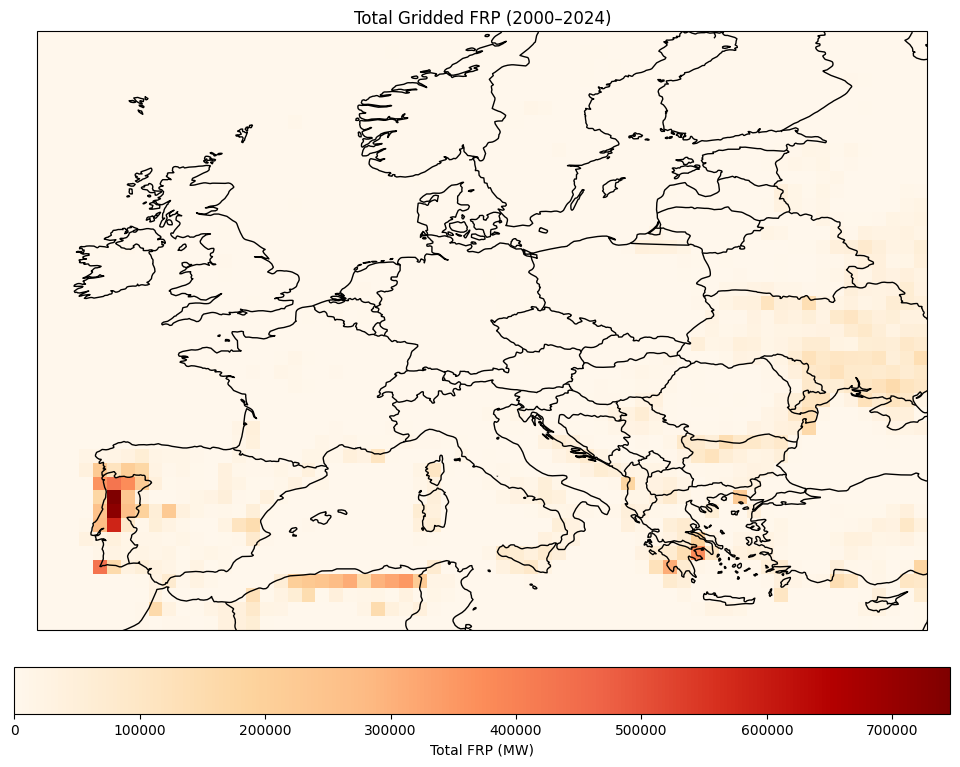

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF dataset
ds = xr.open_dataset(r"E:\IPMA\FRP\FRP_2000_2024.nc")

# Sum over time dimension to get total FRP per grid cell over all days
frp_sum = ds['FRP_sum'].sum(dim='time')

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the summed FRP data
frp_sum.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='OrRd',
    cbar_kwargs={
        'label': 'Total FRP (MW)',
        'orientation': 'horizontal',
        'shrink': 0.8,   # scale the size (optional)
        'pad': 0.05
    }
)

plt.title("Total Gridded FRP (2000–2024)")
plt.tight_layout()
plt.show()

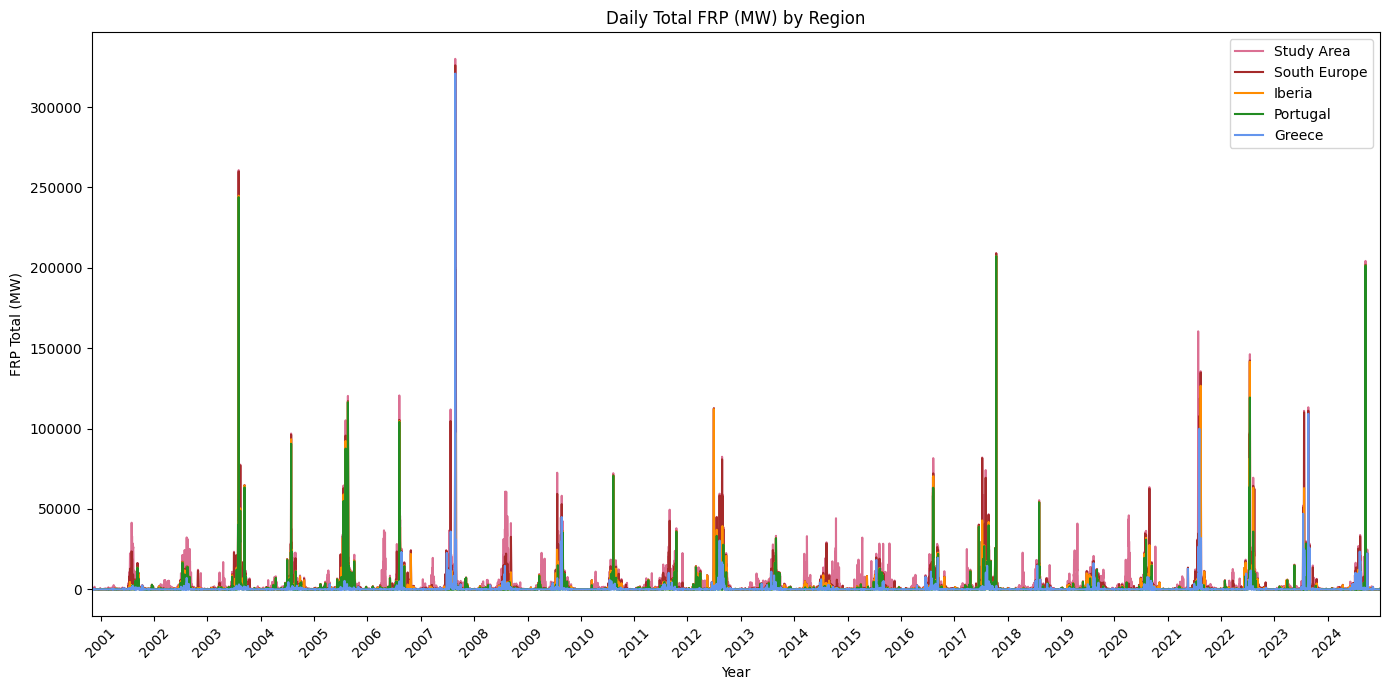

In [5]:
# Time series for daily sum of FRP over defined regions

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Load the NetCDF file
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# Define regions: (lat_min, lat_max, lon_min, lon_max, color)
regions = {
    "Study Area": (34, 66, -12, 36, "palevioletred"),
    "Iberia": (35, 45, -10, 5, "darkorange"),
    "Portugal": (36, 43, -10, -6, "forestgreen"),
    "Greece": (34, 42, 19, 29, "cornflowerblue"),
    "South Europe": (34, 45, -10, 29, "brown"),
}

# Access the daily sum FRP variable
frp_sum = ds["FRP_sum"]

# Dictionary to store time series for each region
region_series = {}

for name, (lat_min, lat_max, lon_min, lon_max, color) in regions.items():
    # Subset the region
    subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Calculate daily regional total (sum over lat/lon)
    daily_total = subset.sum(dim=["latitude", "longitude"], skipna=True)
    
    # Convert to pandas Series
    region_series[name] = pd.Series(daily_total.values, index=pd.to_datetime(daily_total["time"].values))

# Plotting
# Define the order you want to plot regions in
plot_order = ["Study Area", "South Europe", "Iberia", "Portugal", "Greece"]

plt.figure(figsize=(14, 7))

for name in plot_order:
    series = region_series[name]
    plt.plot(series.index, series, label=name, color=regions[name][4])

#for name in plot_order:
   # series = region_series[name].resample("M").sum()
   # plt.plot(series.index, series, label=name, color=regions[name][4])

plt.title("Daily Total FRP (MW) by Region")
plt.xlabel("Year")
plt.ylabel("FRP Total (MW)")
plt.legend()

# Set x-axis limits based on all data
all_dates = pd.concat(region_series.values()).index
plt.xlim(all_dates.min(), all_dates.max())

# Format x-axis yearly
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


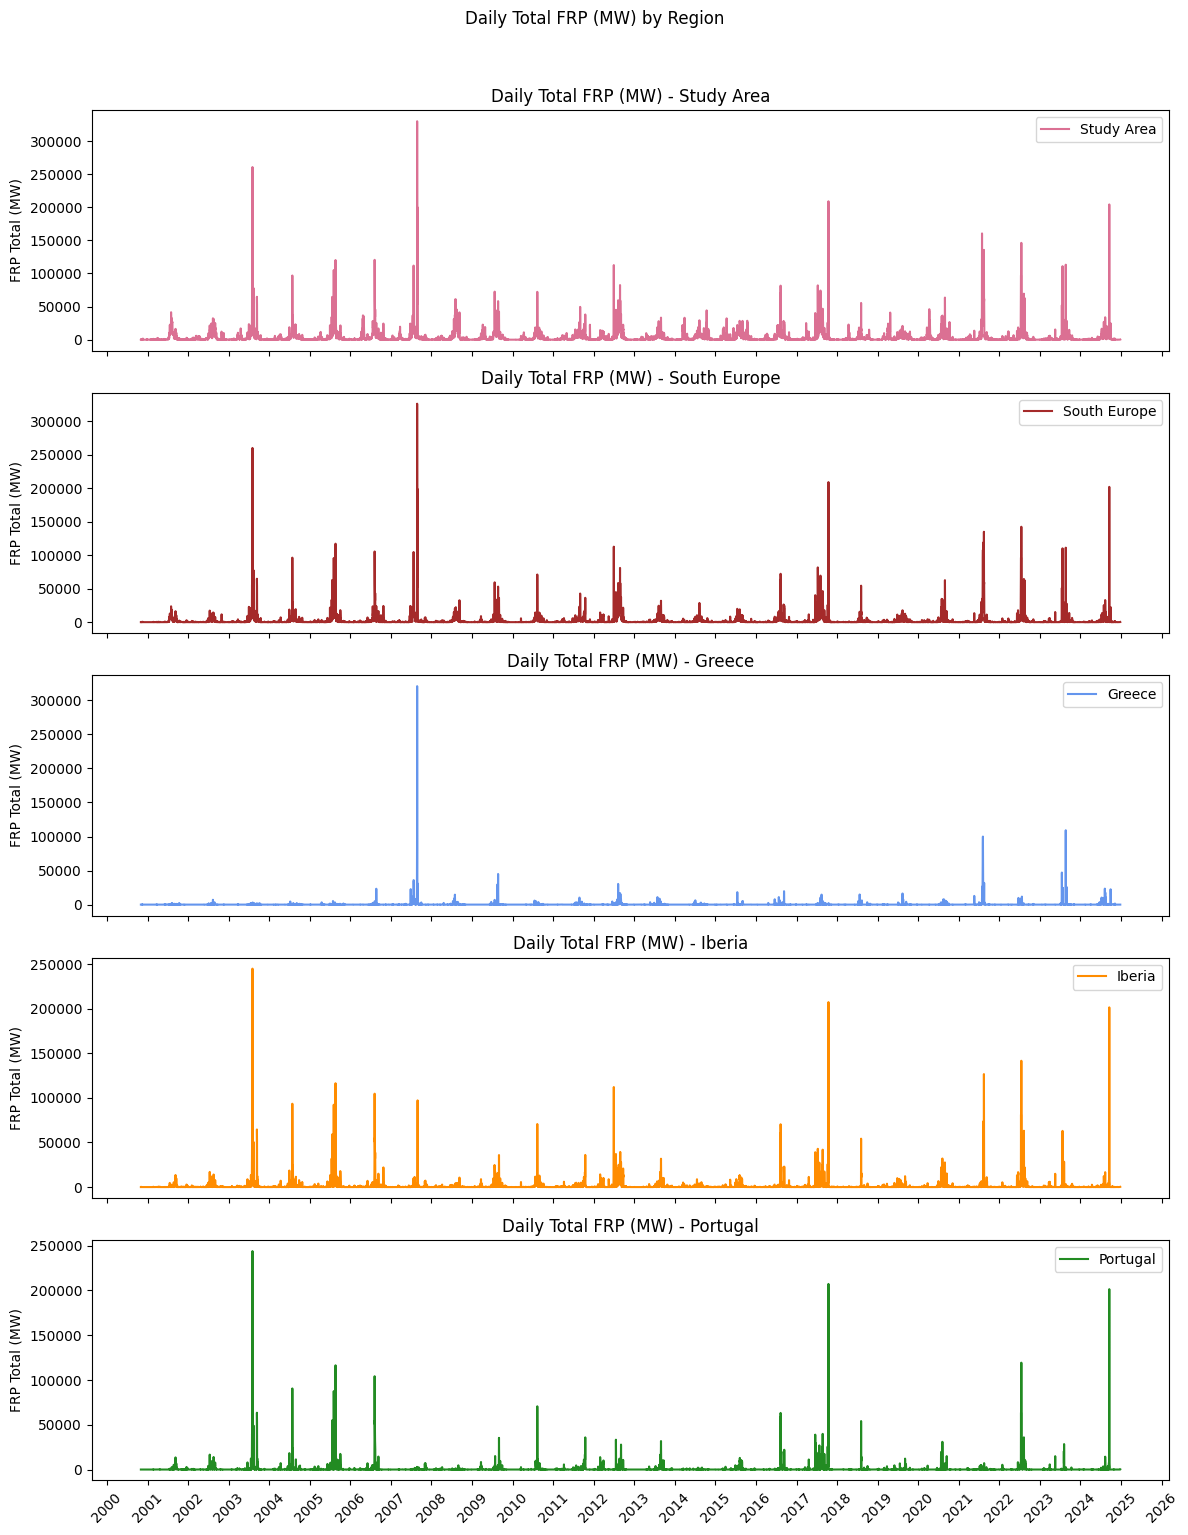

In [6]:
# Time series for daily sum of FRP over defined regions separated plots

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Load the NetCDF file
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# Define regions: (lat_min, lat_max, lon_min, lon_max, color)
regions = {
    "Study Area": (34, 66, -12, 36, "palevioletred"),
    "Iberia": (35, 45, -10, 5, "darkorange"),
    "Portugal": (36, 43, -10, -6, "forestgreen"),
    "Greece": (34, 42, 19, 29, "cornflowerblue"),
    "South Europe": (34, 45, -10, 29, "brown"),
}

# Access the daily sum FRP variable
frp_sum = ds["FRP_sum"]

# Dictionary to store time series for each region
region_series = {}

for name, (lat_min, lat_max, lon_min, lon_max, color) in regions.items():
    # Subset the region
    subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Calculate daily regional total (sum over lat/lon)
    daily_total = subset.sum(dim=["latitude", "longitude"], skipna=True)
    
    # Convert to pandas Series
    region_series[name] = pd.Series(daily_total.values, index=pd.to_datetime(daily_total["time"].values))

# Define the custom order you want the plots to appear in
plot_order = ["Study Area", "South Europe", "Greece", "Iberia", "Portugal"]

# Plotting each region in a separate subplot in the specified order
fig, axes = plt.subplots(len(plot_order), 1, figsize=(12, 3 * len(plot_order)), sharex=True)

for i, name in enumerate(plot_order):
    series = region_series[name]
    axes[i].plot(series.index, series, label=name, color=regions[name][4])
    axes[i].set_ylabel("FRP Total (MW)")
    axes[i].legend()
    axes[i].set_title(f"Daily Total FRP (MW) - {name}")
    
    # Format x-axis yearly
    axes[i].xaxis.set_major_locator(mdates.YearLocator(1))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45)

# Set overall title and adjust layout
plt.suptitle("Daily Total FRP (MW) by Region", y=1.02)
plt.tight_layout()
plt.show()


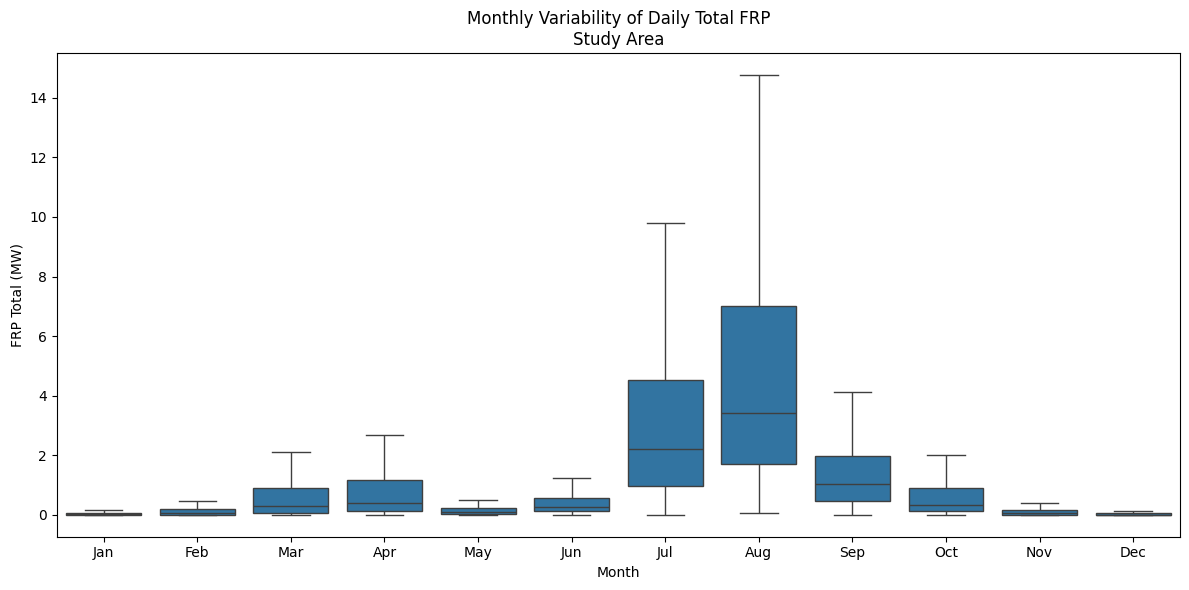

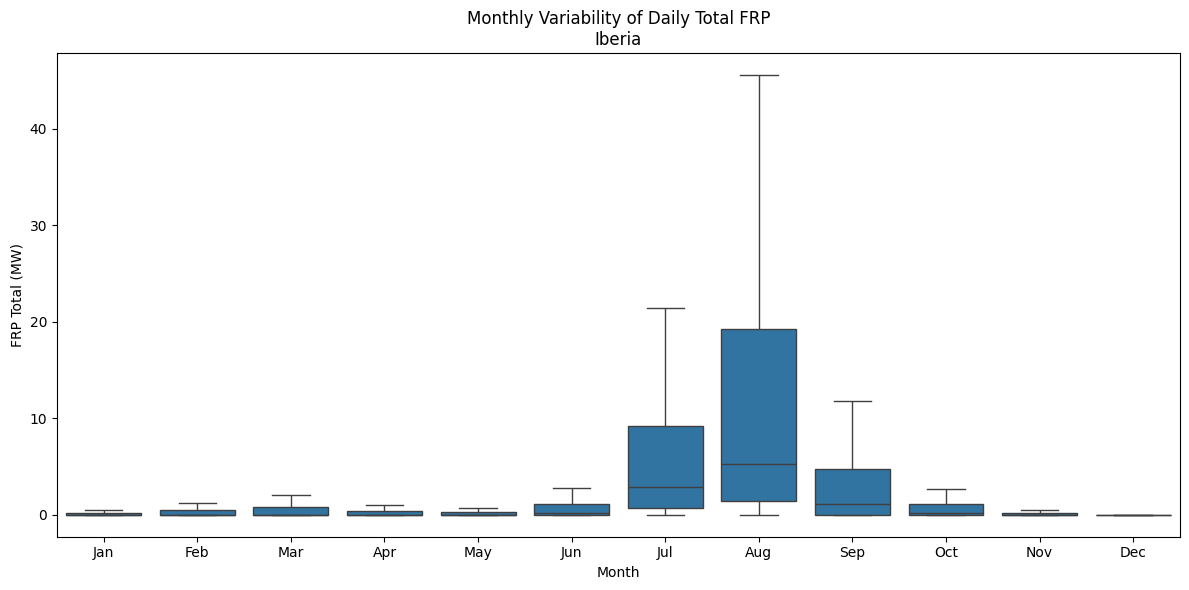

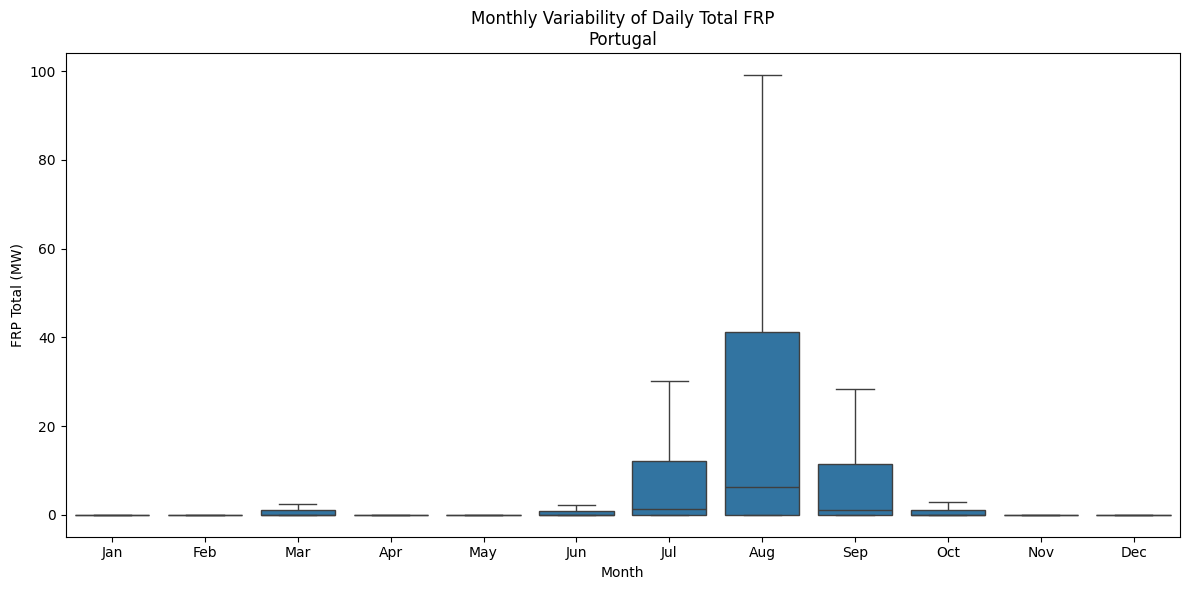

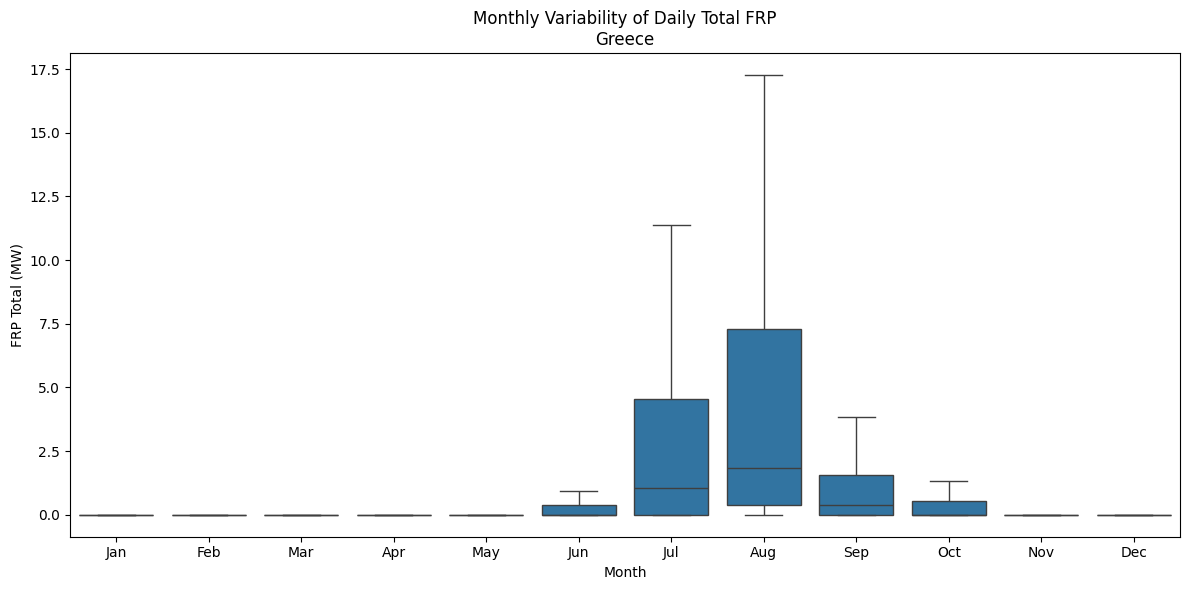

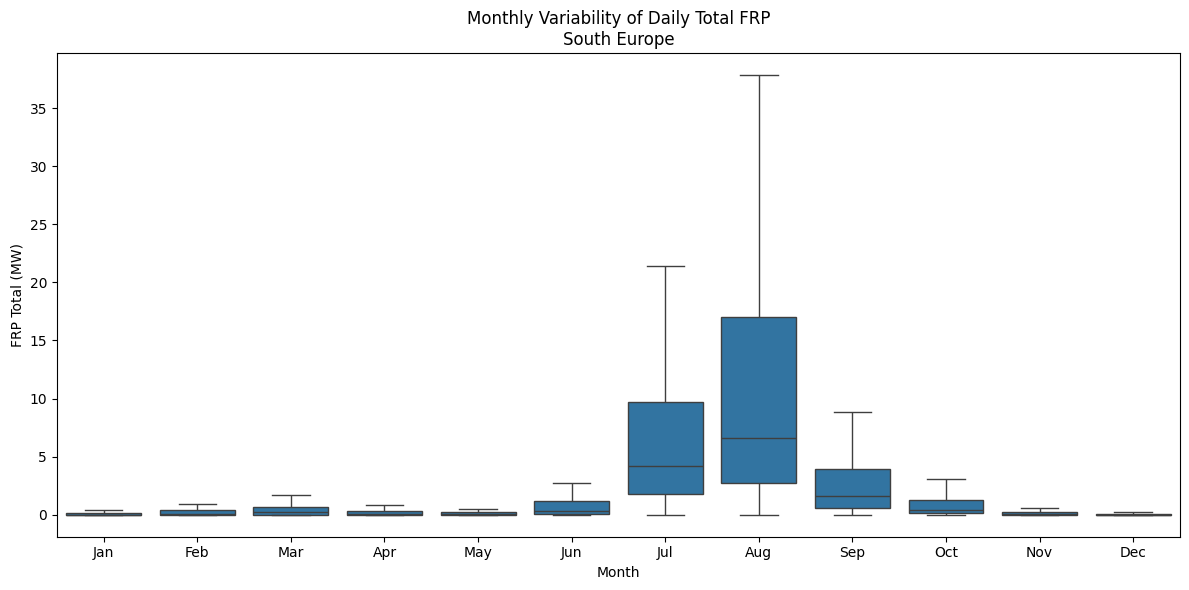

In [7]:
#Boxplot variability by month for every year

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load the NetCDF file ===
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# === Month names for plotting ===
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# === Define regions: (lat_min, lat_max, lon_min, lon_max) ===
regions = {
    "Study Area": (34, 66, -12, 36),
    "Iberia": (35, 45, -10, 5),
    "Portugal": (36, 43, -10, -6),
    "Greece": (34, 42, 19, 29),
    "South Europe": (34, 45, -10, 29),
}

# === Loop through each region ===
for region_name, (lat_min, lat_max, lon_min, lon_max) in regions.items():
    # Subset the dataset to the region
    region_data = ds['FRP_sum'].sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

    # Average over space (grid cells)
    daily_series = region_data.mean(dim=['latitude', 'longitude'], skipna=True)

    # Convert to pandas DataFrame
    df = daily_series.to_dataframe().reset_index()

    # Extract month for grouping
    df['Month'] = df['time'].dt.month
    df['Month Name'] = df['Month'].apply(lambda m: month_names[m - 1])
    
    # Set proper month order
    df["Month Name"] = pd.Categorical(df["Month Name"], categories=month_names, ordered=True)

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Month Name", y="FRP_sum", data=df, showfliers=False, whis=1.5)
    plt.title(f"Monthly Variability of Daily Total FRP\n{region_name}")
    plt.xlabel("Month")
    plt.ylabel("FRP Total (MW)")
    plt.tight_layout()
    plt.show()


In [8]:
#FIRE DAYS AND NO FIRE DAYS

import xarray as xr
import numpy as np
import pandas as pd

# File and threshold
file_path = r"E:/IPMA/FRP/FRP_2000_2024.nc"
threshold = 100  # Define fire presence as FRP > 100

# Define regions: (lat_min, lat_max, lon_min, lon_max)
regions = {
    "Study Area": (34, 66, -12, 36),
    "Iberia": (35, 45, -10, 5),
    "Portugal": (36, 43, -10, -6),
    "Greece": (34, 42, 19, 29),
    "South Europe": (34, 45, -10, 29),
}

# Open dataset and select FRP_sum
ds = xr.open_dataset(file_path)
frp = ds["FRP_max"]  # (time, latitude, longitude)

# Initialize result dictionary
results = {}

# Loop through regions
for region_name, (lat_min, lat_max, lon_min, lon_max) in regions.items():
    # Subset data
    sub_data = frp.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Determine if there's any fire at each day (True if any cell has FRP > 100)
    daily_fire = (sub_data > threshold).any(dim=["latitude", "longitude"])
    
    # Count total fire days
    fire_day_count = daily_fire.sum().item()
    no_fire_day_count = daily_fire.size - fire_day_count
    
    results[region_name] = {
        "Fire Days": fire_day_count,
        "No Fire Days": no_fire_day_count,
        "Total Days": daily_fire.size
    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(results, orient="index")
df.index.name = "Region"
df.reset_index(inplace=True)

# Output
print(df)


         Region  Fire Days  No Fire Days  Total Days
0    Study Area       5476          3345        8821
1        Iberia       2676          6145        8821
2      Portugal       1665          7156        8821
3        Greece       1258          7563        8821
4  South Europe       4017          4804        8821


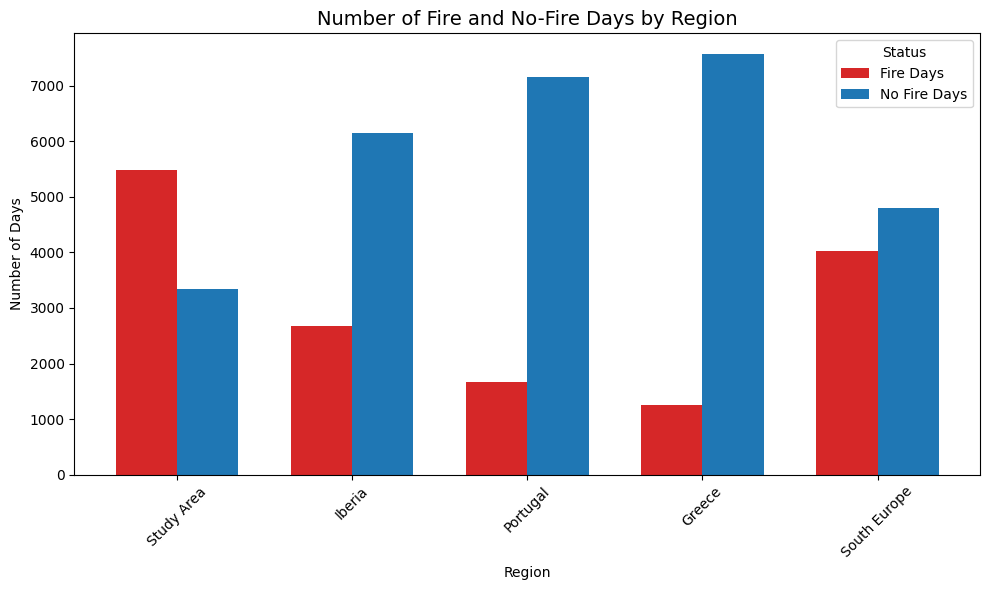

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Colors for fire status
colors = {
    "Fire Days": "tab:red",
    "No Fire Days": "tab:blue"
}

# Melt DataFrame for plotting
df_melted = df.melt(id_vars="Region", value_vars=["Fire Days", "No Fire Days"],
                    var_name="Status", value_name="Day Count")

# Get unique regions and statuses
regions = df["Region"].unique()
statuses = ["Fire Days", "No Fire Days"]
n_statuses = len(statuses)

# Bar settings
x = np.arange(len(regions))
bar_width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, status in enumerate(statuses):
    subset = df_melted[df_melted["Status"] == status]
    values = subset["Day Count"].values
    ax.bar(x + i * bar_width, values, width=bar_width, label=status, color=colors.get(status, "gray"))

# Customization
ax.set_title("Number of Fire and No-Fire Days by Region", fontsize=14)
ax.set_ylabel("Number of Days")
ax.set_xlabel("Region")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(regions, rotation=45)
ax.legend(title="Status")

plt.tight_layout()
plt.show()


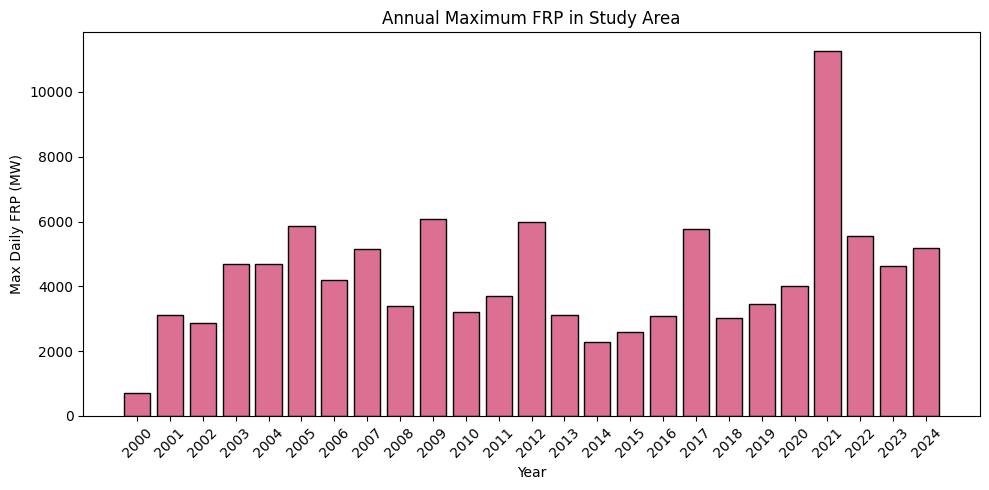

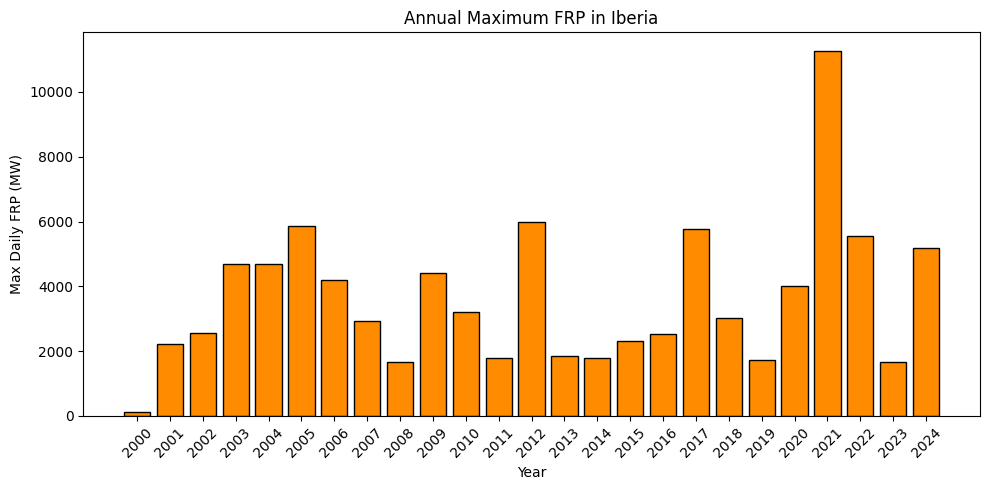

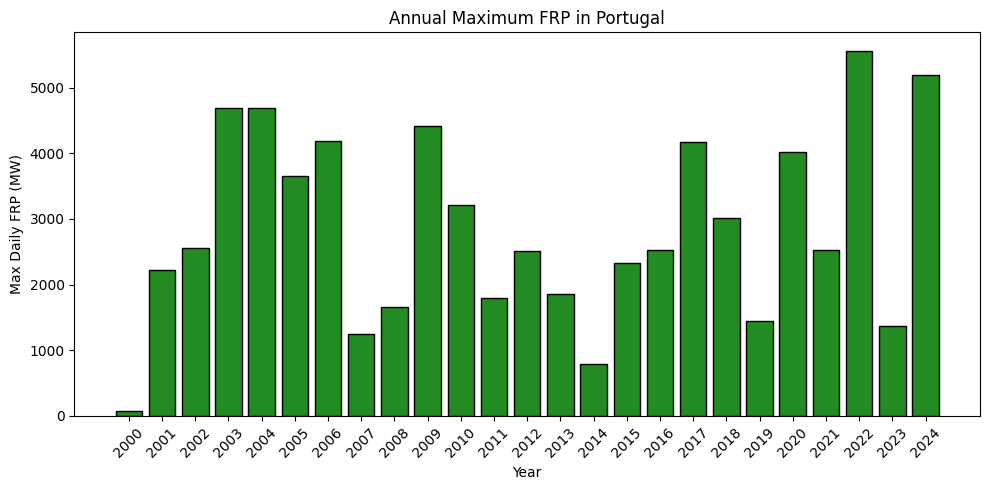

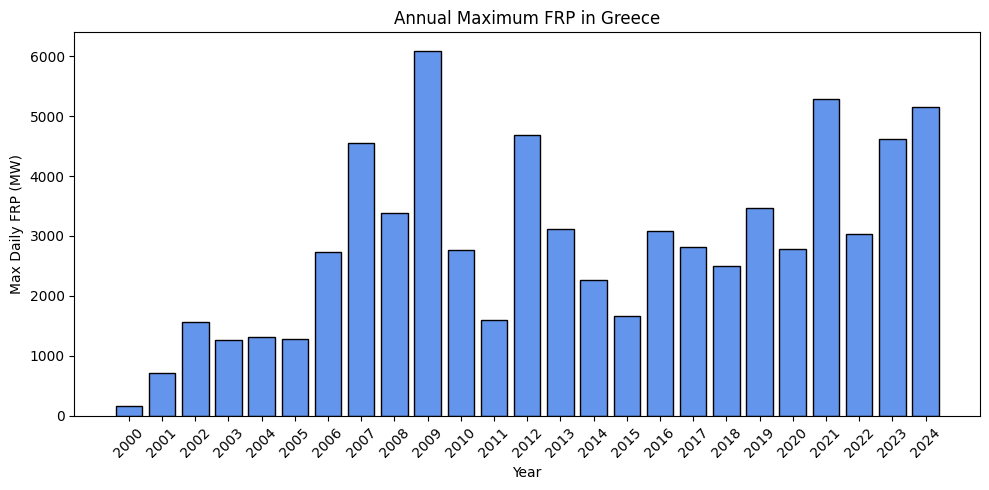

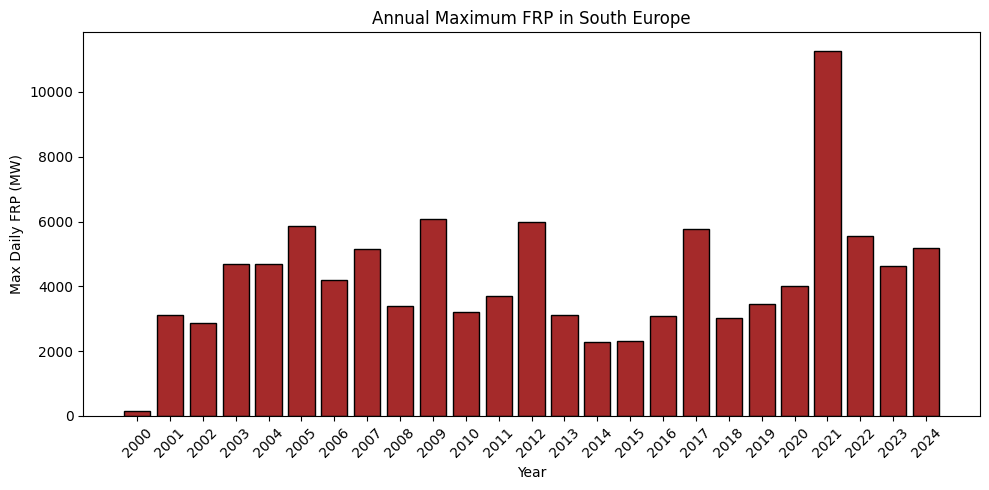

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load dataset
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# Define regions: (lat_min, lat_max, lon_min, lon_max, color)
regions = {
    "Study Area": (34, 66, -12, 36, "palevioletred"),
    "Iberia": (35, 45, -10, 5, "darkorange"),
    "Portugal": (36, 43, -10, -6, "forestgreen"),
    "Greece": (34, 42, 19, 29, "cornflowerblue"),
    "South Europe": (34, 45, -10, 29, "brown"),
}

# Access FRP_max variable
frp_max = ds["FRP_max"]  # (time, latitude, longitude)

# Get available year range from the dataset
years_available = pd.to_datetime(frp_max["time"].values).year
year_start, year_end = years_available.min(), years_available.max()
all_years = np.arange(year_start, year_end + 1)

# Loop through each region
for region_name, (lat_min, lat_max, lon_min, lon_max, color) in regions.items():
    # Subset the region
    subset = frp_max.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Get the daily max over the region
    daily_max = subset.max(dim=["latitude", "longitude"], skipna=True)
    
    # Group by year and compute annual maximum
    yearly_max = daily_max.groupby("time.year").max(skipna=True)

    # Convert to pandas Series and reindex to include all years
    series = pd.Series(yearly_max.values, index=yearly_max["year"].values)
    series = series.reindex(all_years, fill_value=0)  # fill missing years with 0

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(series.index, series.values, color=color, edgecolor='black')
    plt.title(f"Annual Maximum FRP in {region_name}")
    plt.xlabel("Year")
    plt.ylabel("Max Daily FRP (MW)")
    plt.xticks(ticks=all_years, rotation=45)
    plt.tight_layout()
    plt.show()


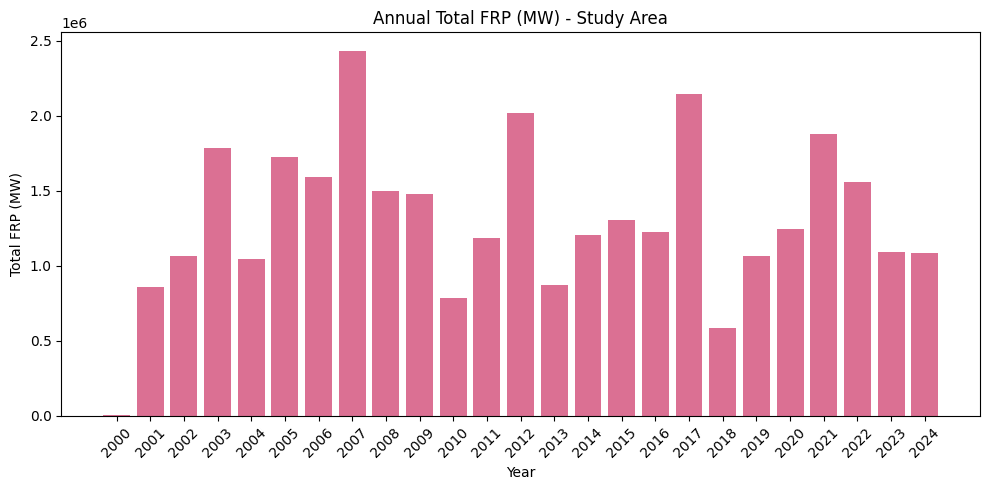

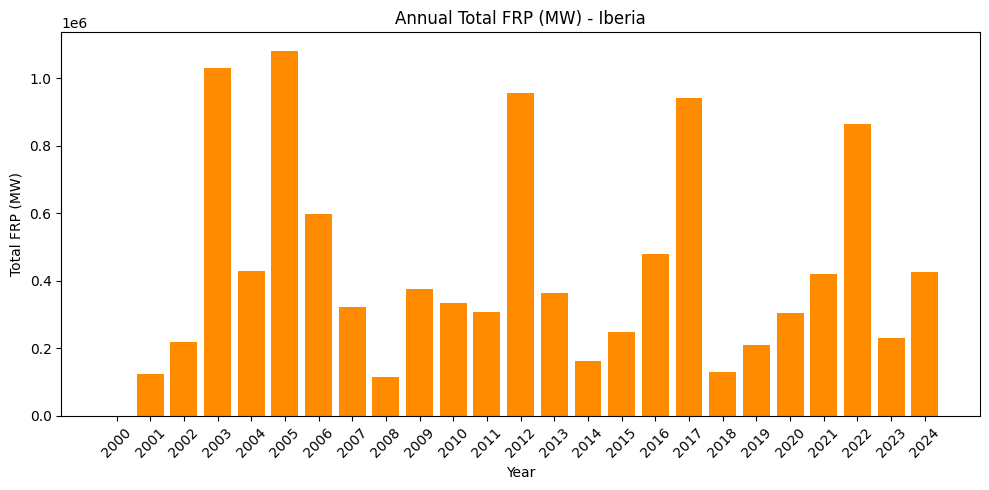

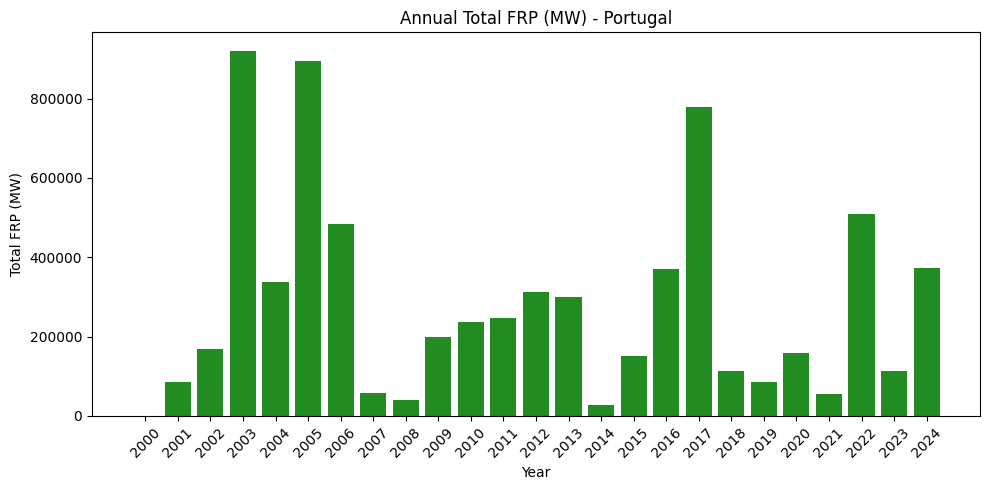

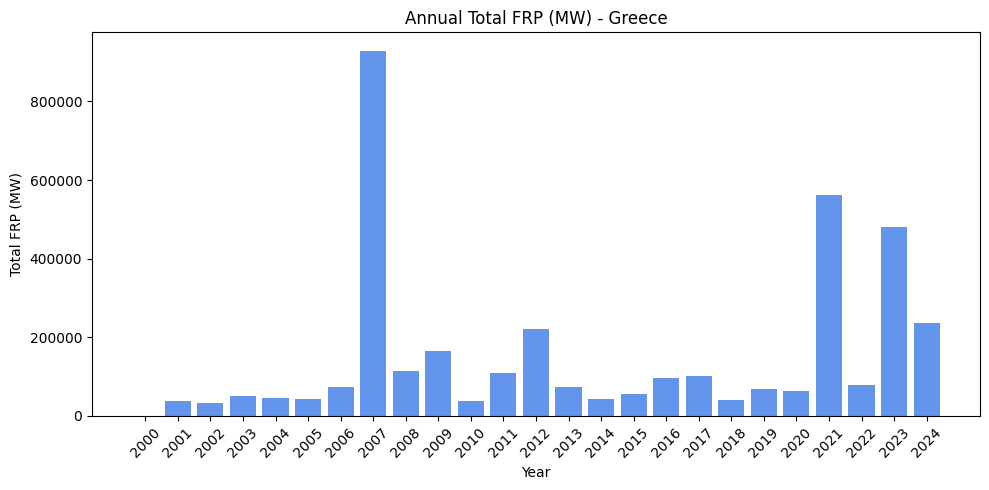

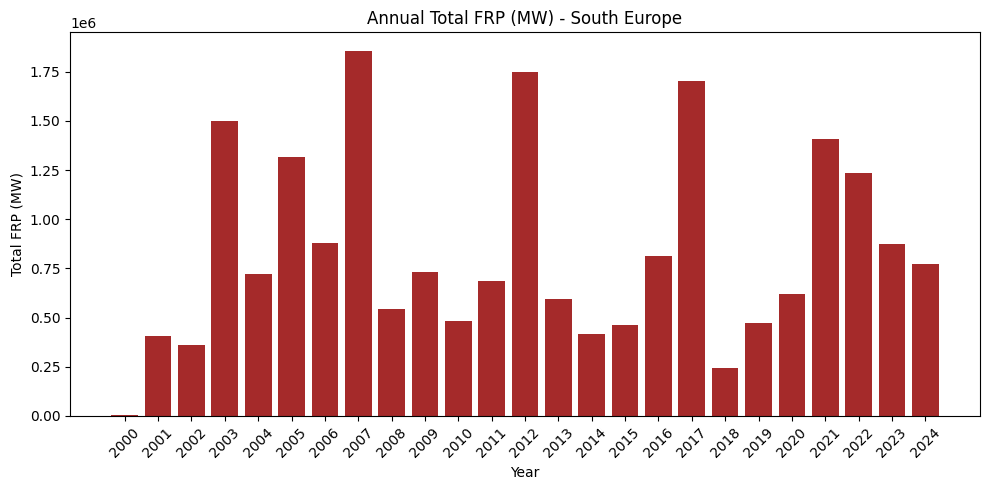

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load the NetCDF file
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# Access the FRP_sum variable
frp_sum = ds["FRP_sum"]  # (time, lat, lon)

# Define regions: (lat_min, lat_max, lon_min, lon_max, color)
regions = {
    "Study Area": (34, 66, -12, 36, "palevioletred"),
    "Iberia": (35, 45, -10, 5, "darkorange"),
    "Portugal": (36, 43, -10, -6, "forestgreen"),
    "Greece": (34, 42, 19, 29, "cornflowerblue"),
    "South Europe": (34, 45, -10, 29, "brown"),
}

# Convert time to pandas datetime
time = pd.to_datetime(frp_sum["time"].values)
years = np.unique(time.year)

# Compute annual total FRP_sum for each region
for name, (lat_min, lat_max, lon_min, lon_max, color) in regions.items():
    # Subset region
    subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Convert to DataArray with datetime index
    subset_df = subset.sum(dim=["latitude", "longitude"], skipna=True).to_series()
    subset_df.index = pd.to_datetime(subset_df.index)
    
    # Group by year and compute annual total
    annual_sum = subset_df.groupby(subset_df.index.year).sum()

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(annual_sum.index.astype(str), annual_sum.values, color=color)
    plt.title(f"Annual Total FRP (MW) - {name}")
    plt.xlabel("Year")
    plt.ylabel("Total FRP (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [12]:
# Classification 4 levels  ≤50 MW (low intensity), 50 to ≤500 MW (moderate to high intensity), 500 ≤ 1000 MW (very high intensity),and >1000 MW (extreme intensity)
